In [2]:
!pip install jsonlines

  Obtaining dependency information for jsonlines from https://files.pythonhosted.org/packages/f8/62/d9ba6323b9202dd2fe166beab8a86d29465c41a0288cbe229fac60c1ab8d/jsonlines-4.0.0-py3-none-any.whl.metadata


In [16]:
import os
import sys
import csv, jsonlines
import numpy as np
import copy
import random
import utils
import seaborn as sns

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:

train_path = os.path.join('data', 'ua.base')
valid_path = os.path.join('data', 'ua.test')

# Load data and shuffle
train_data_list = utils.load_csv_data(train_path, '\t')
print(train_data_list)
random.shuffle(train_data_list)
validation_data_list = utils.load_csv_data(valid_path, '\t')
random.shuffle(validation_data_list)

In file data\ua.base, there are 90570 ratings
The ratings have mean: 3.52, median: 4.0, and variance: 1.27
There are 943 unique users and 1680 unique movies


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [91]:

to_users_dict, to_movies_dict = utils.csv_to_augmented_data_dict(train_path, '\t')


The min, max, and median 'movies per user' is 10, 727, and 55.0
The min, max, and median 'users per movie' is 1, 495, and 25.0
In the training set
There are 213 users with no more than 20 movies
There are 12 movies with no more than 2 user


Text(0.5, 1.0, 'Users per movie')

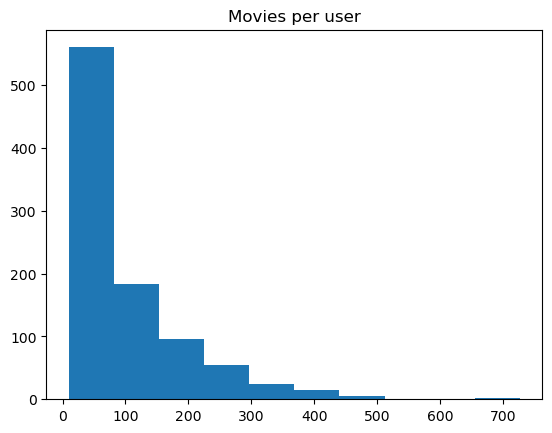

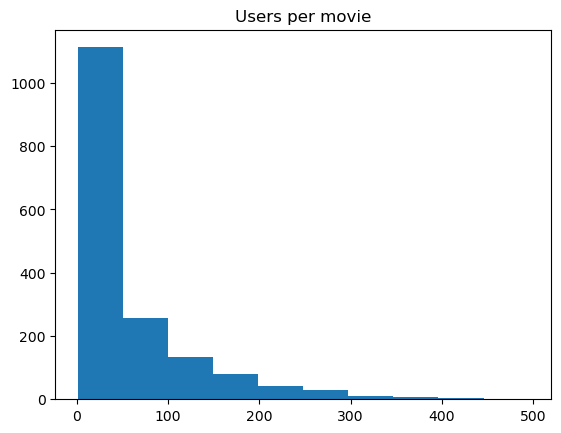

In [15]:
# Calculate min, max, median of number of movies per user
movies_per_user = [len(val) for key, val in to_users_dict.items()]

print("The min, max, and median 'movies per user' is {}, {}, and {}".format(np.min(movies_per_user),
                                                                        np.max(movies_per_user),
                                                                         np.median(movies_per_user)))
# Calculate min, max, median of number of users per movie
users_per_movie = [len(val) for key, val in to_movies_dict.items()]
print("The min, max, and median 'users per movie' is {}, {}, and {}".format(np.min(users_per_movie),
                                                                         np.max(users_per_movie),
                                                                          np.median(users_per_movie)))


# Calculate how many users have watched less than a certain number of movies
count = 0
n_movies_lower_bound = 20
for n_movies in movies_per_user:
    if n_movies <= n_movies_lower_bound:
        count += 1
print("In the training set")
print('There are {} users with no more than {} movies'.format(count, n_movies_lower_bound))

# Calculate how many movies have been watched by less than a certain threshold of users
count = 0
n_users_lower_bound = 2
for n_users in users_per_movie:
    if n_users <= n_users_lower_bound:
        count += 1
print('There are {} movies with no more than {} user'.format(count, n_users_lower_bound))

# Generate histogram for the number of movies watched per user 
f = plt.figure(1)
plt.hist(movies_per_user)
plt.title("Movies per user")

# Generate histogram for the number of users who watched a movie
g = plt.figure(2)
plt.hist(users_per_movie)
plt.title("Users per movie")

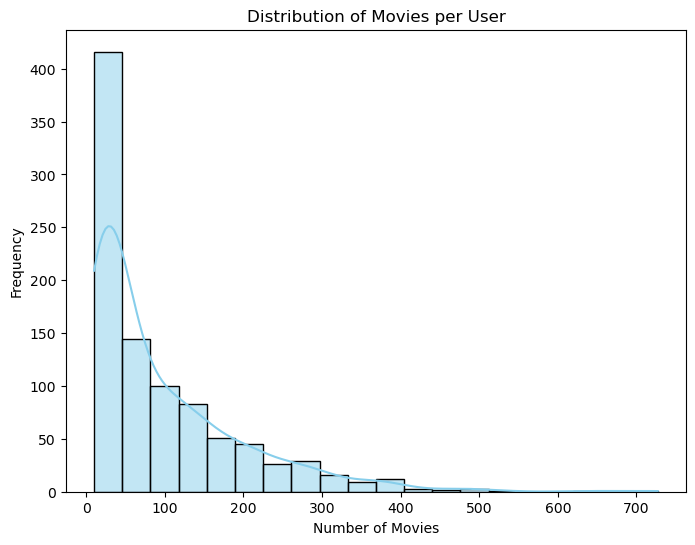

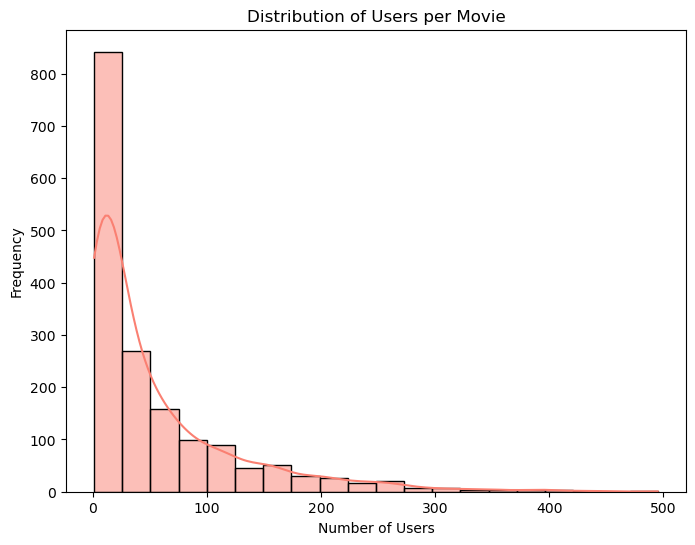

In [18]:

plt.figure(figsize=(8, 6))
sns.histplot(movies_per_user, bins=20, kde=True, color='skyblue')
plt.title("Distribution of Movies per User")
plt.xlabel("Number of Movies")
plt.ylabel("Frequency")
plt.show()

# Generate histogram for the number of users who watched a movie
plt.figure(figsize=(8, 6))
sns.histplot(users_per_movie, bins=20, kde=True, color='salmon')
plt.title("Distribution of Users per Movie")
plt.xlabel("Number of Users")
plt.ylabel("Frequency")
plt.show()

In [21]:
def data_to_matrix(data_list):
    users = []
    movies = []
    ratings = []
    for data in data_list:
        users.append(data['in0'][0])
        movies.append(data['in1'][0])
        ratings.append(data['label'])
    return np.array(users), np.array(movies), np.array(ratings)

In [32]:
train_users, train_movies, train_ratings = data_to_matrix(train_data_list)
validation_users, validation_movies, validation_ratings = data_to_matrix(validation_data_list)

## collaborative filtering

For each user who has rated the movie, we find the ratings they've given for all the movies they've rated.
We subtract the mean of these ratings to center them around zero.
Then, we sum up the squared differences between the centered ratings of each user and the target user.
The resulting value represents the similarity between the users based on their ratings for common movies.

In [35]:
def predict_rating(user_id, movie_id, k=2):
    # Find users who have rated the movie
    users_for_movie = train_users[train_movies == movie_id]
    if len(users_for_movie) == 0:  # If no users have rated the movie
        return 0  # Return default value (e.g., 0)
    
    # Find common movies between the target user and users who have rated the movie
    common_movies = np.intersect1d(train_movies[train_users == user_id], train_movies[train_users == users_for_movie])
    
    # Calculate similarity between users based on common movies
    similarities = []
    for u in users_for_movie:
        common_movies_ratings_user = train_ratings[(train_users == u) & np.isin(train_movies, common_movies)]
        common_movies_ratings_target_user = train_ratings[(train_users == user_id) & np.isin(train_movies, common_movies)]
        similarity = np.sum(common_movies_ratings_user - np.mean(common_movies_ratings_user)) * \
                     np.sum(common_movies_ratings_target_user - np.mean(common_movies_ratings_target_user))
        similarities.append(similarity)
        
    # Get indices of top-k similar users
    top_k_users = np.argsort(similarities)[-k:]
    
    # Predict rating as the average of ratings of top-k similar users
    predicted_rating = np.mean(train_ratings[train_users == users_for_movie[top_k_users[-1]]])
    return predicted_rating

In [36]:
# Make recommendations for each user in the validation set
recommendations = {}
predicted_ratings = []
for i, user_id in enumerate(validation_users):
    movie_id = validation_movies[i]
    rating = predict_rating(user_id, movie_id)
    predicted_ratings.append(round(rating))
    recommendations[(user_id, movie_id)] = round(rating)

    
mae = np.mean(np.abs(predicted_ratings - validation_ratings))
print("Mean Absolute Error (MAE):", mae)


C:\Users\Vishwas\AppData\Local\Temp\ipykernel_2508\2585058364.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  common_movies = np.intersect1d(train_movies[train_users == user_id], train_movies[train_users == users_for_movie])
C:\Users\Vishwas\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vishwas\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Mean Absolute Error (MAE): 0.9102863202545068


In [43]:
# Calculate Mean Squared Error (MSE)
mse = np.mean((predicted_ratings - validation_ratings) ** 2)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 1.4708377518557794


In [ ]:
print("Recommendations:")
for (user_id, movie_id), rating in recommendations.items():
    print(f"User {user_id} might rate Movie {movie_id} with a predicted rating of {rating:.2f}")

Approach 2

In [39]:
# Save training and validation data locally for rating-prediction (regression) task.
utils.write_data_list_to_jsonl(copy.deepcopy(train_data_list), 'train_r.jsonl')
utils.write_data_list_to_jsonl(copy.deepcopy(validation_data_list), 'validation_r.jsonl')

# Format the validation data for testing in the inference step later.
valid_r_data, valid_r_label = utils.data_list_to_inference_format(copy.deepcopy(validation_data_list), binarize=False)

Created train_r.jsonl jsonline file
Created validation_r.jsonl jsonline file


In [40]:
# Define a function to evaluate the performance.
def get_mse_loss(res, labels):
    if type(res) is dict:
        res = res['predictions']
    assert len(res)==len(labels), 'result and label length mismatch!'
    loss = 0
    for row, label in zip(res, labels):
        if type(row)is dict:
            loss += (row['scores'][0]-label)**2
        else:
            loss += (row-label)**2
    return round(loss/float(len(labels)), 2)

In [41]:
def bs2_predictor(test_data, user_dict, is_classification=False, thres=3):
    test_data = copy.deepcopy(test_data['instances'])
    predictions = list()
    for row in test_data:
        userID = str(row["in0"][0])
        # predict movie ID based on local average of user's prediction
        local_movies, local_ratings = zip(*user_dict[userID])
        local_ratings = [float(score) for score in local_ratings]
        predictions.append(np.mean(local_ratings))
        if is_classification:
            predictions[-1] = int(predictions[-1] > 3)
    return predictions

In [42]:
bs2_prediction = bs2_predictor(valid_r_data, to_users_dict, is_classification=False)
print("The validation loss of the Baseline 2 (user-based rating average) is {}".format(
                                     get_mse_loss(bs2_prediction, valid_r_label)))

The validation loss of the Baseline 2 (user-based rating average) is 1.09


## KNN

In [44]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [87]:
k = 10  # Number of neighbors
knn_model = KNeighborsRegressor(n_neighbors=k)

In [93]:
# Train the model
X_train = np.column_stack((train_users, train_movies))  # Features: user IDs and movie IDs
y_train = train_ratings  # Target variable: ratings
knn_model.fit(X_train, y_train)

[[232  81]
 [776 511]
 [716 340]
 ...
 [936   9]
 [378 225]
 [  1 219]]


KNeighborsRegressor(n_neighbors=10)

In [89]:
X_val = np.column_stack((validation_users, validation_movies))  # Features: user IDs and movie IDs
predicted_ratings_knn = knn_model.predict(X_val)

# Round predicted ratings to the nearest integer
predicted_ratings_knn_rounded = np.round(predicted_ratings_knn)

# Calculate Mean Absolute Error (MAE)
mae_knn = mean_absolute_error(validation_ratings, predicted_ratings_knn_rounded)
print("Mean Absolute Error (MAE) for kNN:", mae_knn)

# Calculate Mean Squared Error (MSE)
mse_knn = mean_squared_error(validation_ratings, predicted_ratings_knn_rounded)
print("Mean Squared Error (MSE) for kNN:", mse_knn)

Mean Absolute Error (MAE) for kNN: 0.8594909862142099
Mean Squared Error (MSE) for kNN: 1.3324496288441146
